In [3]:

import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RepeatedKFold, LeaveOneOut
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
import numpy as np, seaborn as sns, matplotlib.pyplot as plt

import eda
import present_value

%load_ext autoreload
%autoreload 2
%reload_ext autoreload


In [4]:
pv = present_value.PresentValue()
anual_increment = pv.fetch_salary_increase_per_year()

In [5]:
filename = "../data/raw/BASE DE DATOS PRESUPUESTOS.xlsx"
preproccesing = eda.EDA(filename)
df = preproccesing.create_dataset(pv.present_value_costs)

c:\Code\practicum\src\eda.py:135: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  w = (df[cols] / totals).fillna(0)


In [6]:
def remove_outliers(df, target: str) -> pd.DataFrame:
    q1, q3 = df[target].quantile(0.05), df[target].quantile(0.95)
    iqr = q3 - q1
    x_clean = (df[target] >= q1 - 1.5*iqr) & (df[target] <= q3 + 1.5*iqr) & (df[target] != 0)
    
    df_clean = df[x_clean]
    return df_clean

In [9]:
def train_model(df_clean, predictor_name, hue_name, target_name):
    X = df_clean[[predictor_name, hue_name]].copy()
    X[predictor_name + ' LOG'] = np.log1p(X[predictor_name])
    y = df_clean[target_name].astype(float)

    pre = ColumnTransformer([
        ('num', StandardScaler(), [predictor_name, predictor_name + ' LOG']),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), [hue_name])
    ])

    svr = SVR(kernel='rbf')
    pipe = Pipeline([('pre', pre), ('svr', svr)])
    model = TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.expm1)

    param_grid = {
        'regressor__svr__C': [3, 10, 100, 300, 500],
        'regressor__svr__epsilon': [0.01, 0.1, 0.3,  1.0],
        'regressor__svr__gamma': ['scale', 'auto', 0.5, 0.1, 0.01],
    }

    cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
    gs = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, refit=True)
    gs.fit(X, y)

    scores = cross_validate(gs.best_estimator_, X, y, cv=cv, 
                           scoring={'r2': 'r2', 'mae': 'neg_mean_absolute_error', 
                                    'rmse': 'neg_root_mean_squared_error'}, n_jobs=-1)
    
    y_predicted = gs.predict(X)
    mape = np.mean(np.abs((y - y_predicted) / y.replace(0, np.nan))) * 100

    print('Best params:', gs.best_params_)
    print({'R2': -scores['test_r2'].mean(), 'MAE': -scores['test_mae'].mean(), 
           'RMSE': -scores['test_rmse'].mean(), 'Full_MAPE%': float(mape)})

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].scatter(y, y_predicted, alpha=0.6); lim = [y.min(), y.max()]
    ax[0].plot(lim, lim, 'r--'); ax[0].set_title('Actual vs Pred'); ax[0].set_xlabel('Actual'); ax[0].set_ylabel('Predicted')
    sns.histplot(y - y_predicted, kde=True, ax=ax[1], color='slateblue'); ax[1].set_title('Residuals')
    plt.tight_layout(); plt.show()
    
    return X, y, y_predicted 
    

*********2.2 TRAZADO Y DISEÑO GEOMÉTRICO*********
Best params: {'regressor__svr__C': 10, 'regressor__svr__epsilon': 0.01, 'regressor__svr__gamma': 0.5}
{'R2': np.float64(-0.1497497134489065), 'MAE': np.float64(10076415.832849527), 'RMSE': np.float64(23046747.840521134), 'Full_MAPE%': 6.7490115718104855}


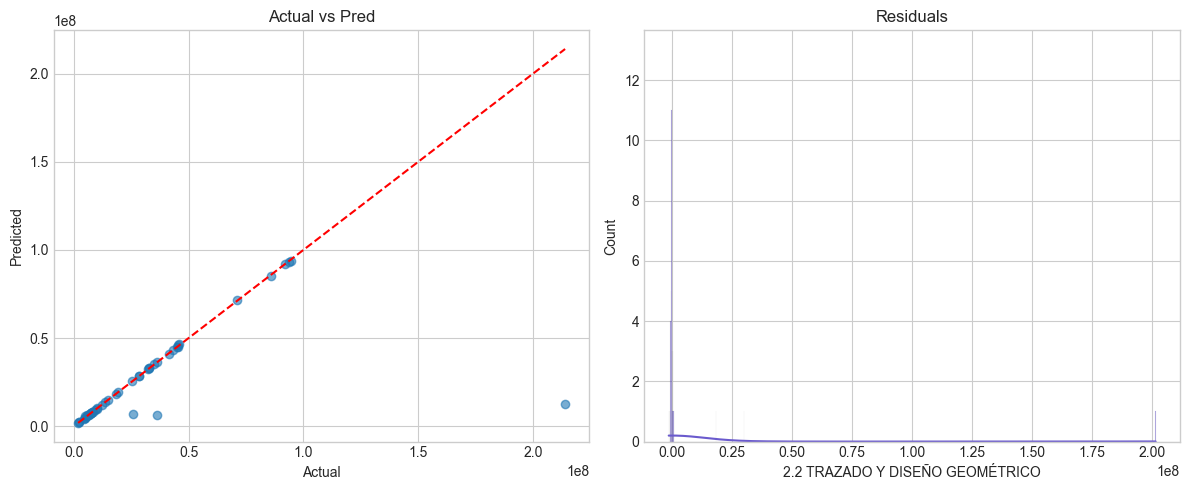

In [10]:
predictor_name = 'LONGITUD KM'
hue_name = 'ALCANCE'
target_names_function_of_longitude = '2.2 TRAZADO Y DISEÑO GEOMÉTRICO'
# target_names_function_of_longitude = '2.4 - SISTEMAS INTELIGENTES'
df_item = df.loc[:, [predictor_name, hue_name, target_names_function_of_longitude]]
df_item_cleaned = remove_outliers(df_item, target_names_function_of_longitude)
print(f'*********{target_names_function_of_longitude}*********')
# preproccesing.show_plots_eda(predictor_name, target_names_function_of_longitude, hue_name, df_item_cleaned)
X_test, y_test, y_predicted   = train_model(df_item_cleaned, predictor_name, hue_name, target_names_function_of_longitude)

In [ ]:
predictor_name = 'LONGITUD KM'
hue_name = 'ALCANCE'
target_names_function_of_longitude = ['2.2 TRAZADO Y DISEÑO GEOMÉTRICO', 
                                      '2.3 - SEGURIDAD VIAL',
                                      '2.4 - SISTEMAS INTELIGENTES', 
                                      '5 - TALUDES',
                                      '6 - PAVIMENTO',
                                      '7 - SOCAVACIÓN',
                                      '11 - PREDIAL',
                                      '12 - IMPACTO AMBIENTAL',
                                      '15 - OTROS - MANEJO DE REDES']

for target_name in target_names_function_of_longitude:
    df_item = df.loc[:, [predictor_name, hue_name, target_name]]
    df_item_cleaned = remove_outliers(df_item, target_name)
    print(f'*********{target_name}*********')
    preproccesing.show_plots_eda(predictor_name, target_name, hue_name, df_item_cleaned)
    train_model(df_item_cleaned, predictor_name, hue_name, target_name)
    break

In [11]:
X_test['ACTUAL'] = y_test
X_test['PREDICTED'] = y_predicted
output = X_test.drop(columns=['LONGITUD KM LOG'])
output

,LONGITUD KM,ALCANCE,ACTUAL,PREDICTED
0,15.760,Segunda calzada,3.233665e+07,3.266729e+07
1,22.200,Segunda calzada,4.555036e+07,4.509006e+07
2,15.000,Rehabilitación,3.505602e+07,3.540365e+07
3,3.120,Nuevo,7.291653e+06,7.363622e+06
4,3.370,Segunda calzada,7.875920e+06,7.945981e+06
5,0.800,Cosntrucción,1.869655e+06,1.888276e+06
6,3.500,Segunda calzada,8.179739e+06,8.243371e+06
7,5.170,Segunda calzada,1.208264e+07,1.195938e+07
8,19.310,Puesta a punto,4.512879e+07,4.467882e+07
9,8.210,Puesta a punto,1.918733e+07,1.912103e+07
